<a href="https://colab.research.google.com/github/s-jainr/deep-learning-sp23/blob/main/Deep_Learning_Final_Project_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install pytreebank
import pytreebank
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset from disk
dataset = pytreebank.load_sst("/path/to/sentiment/")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
# Extract the train, validation, and test data
train_data = dataset['train'][:1000]

# Build the vocabulary
vocab = set()
for sentence in train_data:
    sentence = sentence.to_labeled_lines()[0][1]
    words = sentence.lower().split()
    for word in words:
        vocab.add(word)

# Create the word-to-index and index-to-word mappings
word_to_index = {}
index_to_word = {}
for i, word in enumerate(vocab):
    word_to_index[word.lower()] = i
    index_to_word[i] = word.lower()

# Convert the sentences to sequences of word indices
train_sequences = []
for sentence in train_data:
    sentence = sentence.to_labeled_lines()[0][1]
    words = sentence.lower().split()
    sequence = [word_to_index[word.lower()] for word in words]
    train_sequences.append(sequence)

# Pad the sequences to a fixed length
max_length = max(len(sequence) for sequence in train_sequences)
train_sequences = np.array([sequence + [0]*(max_length-len(sequence)) for sequence in train_sequences])

# Convert the labels to one-hot vectors
train_labels = np.zeros((len(train_data), 5))
for i, sentence in enumerate(train_data):
    train_labels[i][sentence.label] = 1

In [25]:
sums = np.sum(train_labels, axis=0)

for i in range(len(sums)):
  print(f"sentences in class {i}: {sums[i]:.0f}")

sentences in class 0: 8
sentences in class 1: 42
sentences in class 2: 146
sentences in class 3: 488
sentences in class 4: 316


In [26]:
train_x = []
for seq in train_sequences:
  matrix = []
  for encoding in seq:
    seq_hot = np.zeros(len(vocab))
    seq_hot[encoding] = 1
    matrix.append(seq_hot)
  train_x.append(matrix)

train_x = np.array(train_x)

In [27]:
train_x, test_x, train_y, test_y = train_test_split(train_x, train_labels, test_size=0.2, random_state=47)

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 50, 32)            461408    
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 25, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 23, 64)            6208      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 11, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 9, 128)            24704     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 4, 128)          

In [29]:
es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

network_history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=1000, batch_size=32, callbacks = [es])

Epoch 1/1000
25/25 [==============================] - 3s 47ms/step - loss: 1.2839 - accuracy: 0.4700 - val_loss: 1.2218 - val_accuracy: 0.4750
Epoch 2/1000
25/25 [==============================] - 1s 38ms/step - loss: 1.1299 - accuracy: 0.4913 - val_loss: 1.2288 - val_accuracy: 0.4750
Epoch 3/1000
25/25 [==============================] - 1s 44ms/step - loss: 1.0310 - accuracy: 0.4975 - val_loss: 1.2177 - val_accuracy: 0.5100
Epoch 4/1000
25/25 [==============================] - 1s 42ms/step - loss: 0.6902 - accuracy: 0.7437 - val_loss: 1.5012 - val_accuracy: 0.3900
Epoch 5/1000
25/25 [==============================] - 1s 40ms/step - loss: 0.3831 - accuracy: 0.8288 - val_loss: 2.2051 - val_accuracy: 0.3450
Epoch 6/1000
25/25 [==============================] - 1s 39ms/step - loss: 0.2118 - accuracy: 0.9375 - val_loss: 3.0491 - val_accuracy: 0.3650
Epoch 7/1000
25/25 [==============================] - 1s 48ms/step - loss: 0.1463 - accuracy: 0.9488 - val_loss: 3.9039 - val_accuracy: 0.3250

In [30]:
import time

def progress_bar(current, total, start_time, bar_length=20):
    fraction = current / total
    arrow = int(fraction * bar_length - 1) * '-' + '>'
    padding = int(bar_length - len(arrow)) * ' '
    ending = '\n' if current == total else '\r'
    time_diff = round(time.time() - start_time)

    print(f'{current} / {total}\t\t'
          f'Progress: [{arrow}{padding}] {int(fraction * 100):02d}%\t\t'
          f'Elapsed Time: \t{(time_diff // 60):02d}:{time_diff % 60:02d}', end=ending)

In [31]:
model.evaluate(test_x, test_y)

7/7 [==============================] - 0s 27ms/step - loss: 1.2177 - accuracy: 0.5100


[1.2177397012710571, 0.5099999904632568]

7/7 [==============================] - 0s 28ms/step


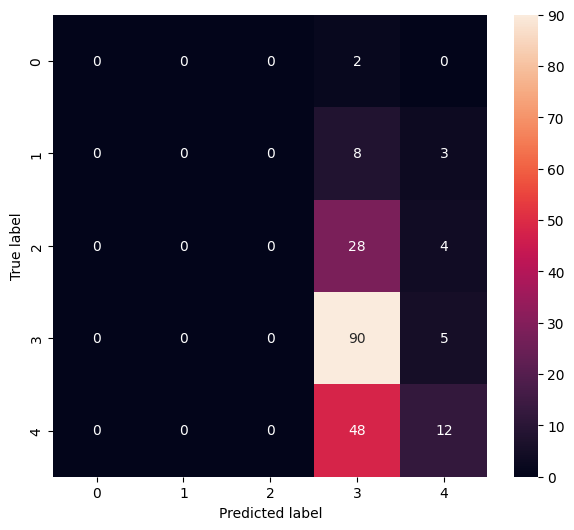

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# calculate the confusion matrix
preds = model.predict(test_x)
conf = confusion_matrix(np.argmax(test_y, axis=1), np.argmax(preds, axis=1))

# plot the confusion matrix as a heatmap
plt.figure(figsize=(7,6))
sns.heatmap(conf, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()